Import Libraries

In [1]:
import skimage
import numpy as np
import cv2

from sklearn import svm
from sklearn.externals import joblib
from functions import show, put_labels

from constants import *
from skimage.feature import hog

In [2]:
def drop_features(lt,j=2):
    lt = [lt[i] for i in range(len(lt)) if i%j==0]
    return lt

def filter_features(fd):
    return [f for f in fd if len(f)==2048]

def filter_region(region):
    width = region[2] - region[0]
    height = region[3] - region[1]
    # Incorrect region
    if width==0 or height==0:
        return True
    # distorted rects
    if width / height > 4 or height / width > 4:
#         print width/height,height/width
        return True
    if width*height < 4000:
        return True
    return False

Load positive and negatives from train images.

In [3]:
class_positives = np.load('cat_vs_dogs_positives.npy')
class_negatives = np.load('cat_vs_dogs_negatives.npy')

#get dicts from numpy array
class_positives = class_positives[()]
class_negatives = class_negatives[()]

Extract train data

In [7]:

X,y = [],[]
background = []
#maps each class to it's label
class_num = {}
for category in enumerate(class_positives.keys()):
    #print category
    f = class_positives[category[1]][:500]
    X.extend(f)
    y.extend([category[0]]*len(f))  
    background.extend(drop_features(class_negatives[category[1]],j=100))
    class_num[category[1]] = category[0]
    #print len(f)
    #print len(background)
X.extend(background)
y.extend([20]*len(background))
X = np.array(X)
y = np.array(y)

In [8]:
print "No. of feature vectors for training:",len(X)

No. of feature vectors for training: 9028


Feature Extraction

In [9]:
def extract(image,box=None):
    """Returns hog feature descriptor for an image.
    """
    #print 'initial',image.shape
    #print len(image)
    if box is not None:
        image = image[box[0]:box[2],box[1]:box[3]]
    
    #resize image
    #print image.shape
    #print len(image)
    image = resize(image)
    #print image.shape
    #image = color.rgb2gray(img)
    fd = hog(image, orientations=8, pixels_per_cell=(image.shape[1]/16, image.shape[0]/16),
                    cells_per_block=(1, 1), visualise=False, transform_sqrt=True)
    #print len(fd)
    return fd

def resize(image):
    if image.shape[1]/image.shape[0] >= 2:
        image = cv2.resize(image,(128,64))
    elif float(image.shape[1])/image.shape[0] <= 0.5:
        image = cv2.resize(image,(64,128))
    else:
        image = cv2.resize(image,(128,128))
    return image

Load test annotation for bounding boxes.

In [10]:
#load test data
test_ground_truth = np.load('test_ground_truth.npy')
test_ground_truth[0][1]

[{'dog': (48, 240, 195, 371)}, {'person': (8, 12, 352, 498)}]

In [11]:
#extract test data
Xtest,ytest = list(),list()
imgs,i_boxes = list(),list()
filtered = 0
for i in range(len(test_ground_truth)):
    boxes = list()
    for dt in test_ground_truth[i][1]:
        #if 'dog' in dt or 'cat' in dt:
        if filter_region(dt.values()[0]):
            filtered = filtered + 1
        else:
            boxes.append(dt)
    if len(boxes)!=0:
        name = test_ground_truth[i][0]
        imgs.append(name)
        i_boxes.append(boxes)
        img = cv2.imread(folder_test + '/' + name,0)
        #print name,boxes
        for box in boxes:
            #print box.values()[0]
            p_box = box.values()[0]
            p_box = p_box[1::-1] + p_box[3:1:-1] 
            Xtest.append(extract(img,p_box))
            ytest.append(class_num[box.keys()[0]])
            
print "Filtered no. of test boxes:",filtered

Filtered no. of test boxes: 1894


Load/Train Classifier

In [16]:
# len(ytest)
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline

# print "Reducing dimensions using PCA"
# pca = PCA(whiten=True)
# svc = svm.SVC(probability=True,class_weight='balanced',verbose=True,kernel='rbf')
# pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

n_components = [100, 300, 900, 1500]

In [17]:
# print 'Training ...'
# print 'Feature Vectors:',len(X)
from sklearn.grid_search import GridSearchCV
# print("Fitting the classifier to the training set")
param_grid = {'C': [1, 10, 100],'gamma':[0.001 , 0.01, 0.1], 'kernel': ['rbf']}
# # clf = GridSearchCV(pipe,  dict(pca__n_components=n_components,svc__C=[1,10]),n_jobs=-1)
# clf = GridSearchCV(pipe,  dict(pca__n_components=n_components,svc__C=param_grid['C'],
#                                svc__gamma=param_grid['gamma']),n_jobs=16)
# clf = clf.fit(X, y)
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

# clf = svm.SVC(gamma=0.01, C=100,probability=True)
# clf.fit(X, y)

In [18]:
from sklearn.externals import joblib 
# joblib.dump(clf, 'Classifier 2/clf.pkl')
clf = joblib.load('Classifier 2/clf.pkl') 

Testing on test images

In [19]:
pred = clf.predict(Xtest)
from sklearn import metrics
conf_mat = metrics.confusion_matrix(ytest,pred)
print("Accuracy: %0.4f" % metrics.accuracy_score(ytest,pred))
print "{0}".format(metrics.classification_report(ytest,pred))
print("Confusion matrix:\n{0}" .format(conf_mat))


Accuracy: 0.3525
             precision    recall  f1-score   support

          0       0.20      0.27      0.23        91
          1       0.27      0.54      0.36       138
          2       0.49      0.49      0.49       136
          3       0.43      0.46      0.45        99
          4       0.16      0.47      0.24        64
          5       0.21      0.38      0.27       160
          6       0.15      0.28      0.20       218
          7       0.49      0.53      0.51        86
          8       0.15      0.36      0.21       144
          9       0.81      0.20      0.32      1479
         10       0.41      0.52      0.46       115
         11       0.36      0.38      0.37        86
         12       0.50      0.53      0.52        88
         13       0.71      0.56      0.63       372
         14       0.21      0.28      0.24       162
         15       0.78      0.75      0.76       102
         16       0.59      0.40      0.47       399
         17       0.18      

/home/arjun/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
import pandas as pd
y_actu = pd.Series(ytest, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'])
print "{0}".format(df_confusion)
f = open('conf_mat','w')
f.write("{0}".format(df_confusion))
f.close()

Predicted  0    1   2   3   4   5    6   7    8    9  ...  11  12   13  14  \
Actual                                                ...                    
0          25   14   3   0  15   3   17   0    5    1 ...   0   0    0   1   
1          10   75   1   0  13   0   13   0    9    0 ...   1   0    0   3   
2           2    4  66   3   2   3    9   0    6    3 ...   1   2    0   3   
3           4    2   0  46   1   2    3   1    7    3 ...   1   0    9   4   
4           5    7   0   0  30   1    8   0    3    3 ...   0   0    0   0   
5           2    3   1   0   5  61   14   0   19    2 ...   3   1    6   4   
6          10   23   6   1  18  14   61   0   46    9 ...   1   1    0   2   
7           0    1   1   1   0   0    0  46    0    0 ...   3   0    4   2   
8           4    4   4   1   5  14   23   0   52    5 ...   2   1    2   4   
9          41  105  29  31  58  98  170   2  117  296 ...  15  13   26  96   
10          1    7   0   0   5   3    3  12    2    0 ...   1   

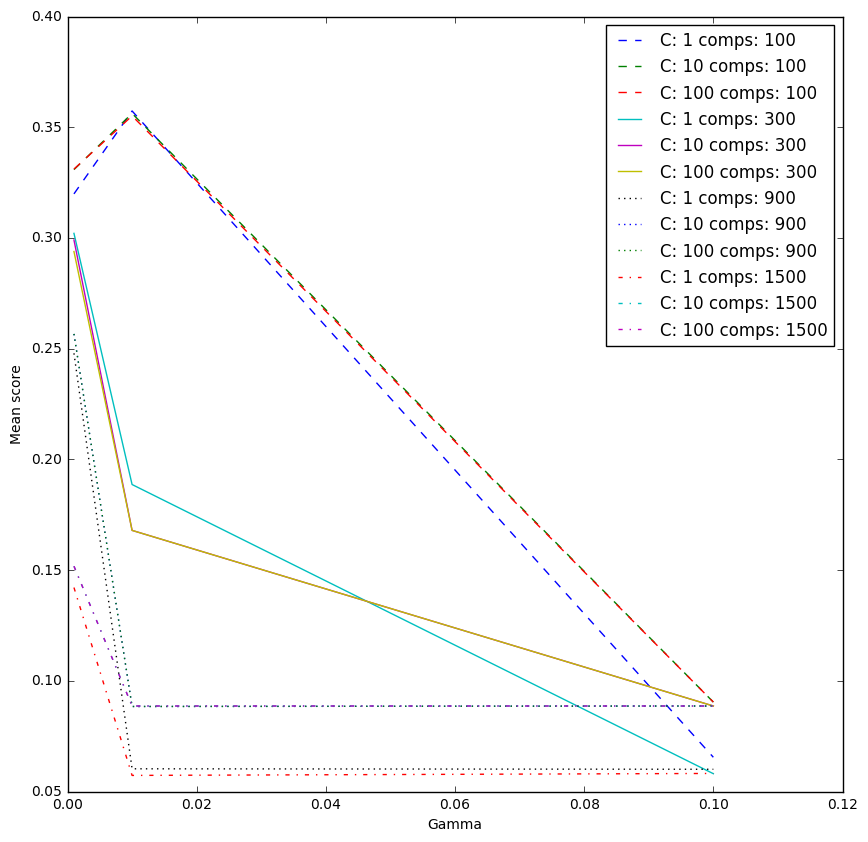

In [21]:
#Draw tuning graphs
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(n_components), len(param_grid['C']), len(param_grid['gamma']))
#print scores
plt.figure(figsize=(10,10))
linestyles = ['--','-',':','-.']
for j in range(len(n_components)):
    for ind, i in enumerate(param_grid['C']):
        plt.plot(param_grid['gamma'], scores[j][ind], label='C: ' + str(i)+' comps: '+str(n_components[j]), 
                 linestyle=linestyles[j])

plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')

plt.show()


Performing detection on test images

In [22]:
test_regions = np.load('test_regns.npy')

from extract import get_overlapping

def filter_detections(detections):
    detections = sorted(detections,key = lambda detection:detection[1], reverse=True)
    remove = [False]*len(detections)
    for i in range(len(detections)):
        if remove[i] is True:
            continue
        for j in range(i+1,len(detections)):
            if remove[j] is True:
                continue
            if get_overlapping(detections[i][0],detections[j][0])>0.3:
                remove[j] = True
    detections = [detections[i] for i in range(len(detections)) if remove[i] is False]        
    return detections

def filter_regions(regions):
    """Remove equal regions"""
    f_regions = []
    d = {}
    for region in regions:
        d[region]=True
    for i in range(len(regions)): 
        if d[regions[i]]:
            d[regions[i]] = False
            f_regions.append(regions[i])
    return f_regions

In [23]:
# from os import path
# img_detects = []
# for dt in test_regions[0:3]:
#     name = path.join(folder_test,dt.keys()[0])
#     img = cv2.imread(name,0)
#     regions = filter_regions(dt.values()[0])
#     probs,labels = list(),list()
#     regions = [region for region in regions if not filter_region(region)]
#     print dt.keys()[0]
#     for regn in regions:
#         #print regn
#         fd = extract(img,regn)
#         label = clf.predict([fd])
#         probs.append(clf.predict_proba([fd])[0][label])
#         print label,clf.predict_proba([fd])
#         labels.append(label)
#     detections = zip(regions,probs,labels)
#     detections = filter_detections(detections)
#     img_detects.append({dt.keys()[0]:detections})
    
# try:
#     np.save('img_detects_mod.npy',img_detects)
# except Exception as e:
#     print str(e)
img_detects = np.load('img_detects_mod.npy')   #contains test image detections

Threshold detections



In [24]:
def get_classification(detections):
    classification=[]
    added = [False]*20
    for detection in detections:
        if detection[2]==20:
            continue
        add = False
        if not added[detection[2][0]]:
            if detection[1]>0.25:
                add = True
                added[detection[2][0]] = True
        elif detection[1]>0.6:
            add = True
            
        if add:
            box = detection[0]
            object_box = box[1::-1] + box[3:1:-1] 
            classification.append([detection[2],detection[1],object_box])
            #print detection
            
    return classification


Write results to files for submission to PASCAL VOC

In [25]:
files = [0]*20
for name,label in class_num.items():
    files[label] = open('comp3_det_test_'+name+'.txt', 'w')
for detects in img_detects:
    detects = detects.items()[0]
    detection = get_classification(detects[1])
    for dt in detection:
        line = detects[0][:-4]+' '+str(dt[1][0])+' '+str(dt[2][0])+' '+str(dt[2][1])+' '+str(dt[2][2])+' '+str(dt[2][3])+'\n'
        files[dt[0][0]].write(line)
        print line
    #print detection,detects[0]

for f in files:
    f.close()
#print [d for d in detection if d != -1]

000001 0.584350738407 301 36 352 176

000001 0.54595070338 199 0 352 50

000001 0.442094959828 46 310 297 467

000001 0.417157155939 129 14 282 140

000001 0.371936535417 255 405 352 459

000001 0.356377077215 227 425 338 499

000001 0.344701049869 171 226 237 302

000001 0.328495042881 279 73 328 179

000001 0.323338136231 282 324 332 405

000001 0.287715297857 58 251 108 349

000001 0.2627622333 141 106 200 175

000002 0.647867309779 141 193 233 299

000002 0.533113155838 2 144 85 201

000002 0.457561527788 0 316 64 399

000002 0.423209362874 6 221 111 274

000002 0.413442440583 0 215 154 499

000002 0.392175411229 265 170 311 284

000002 0.363383336219 163 338 222 465

000002 0.362507565876 48 244 131 310

000002 0.361485832107 190 44 276 93

000002 0.255692753813 75 349 127 459

000003 0.743874669001 251 294 499 358

000003 0.66655208334 0 301 263 361

000003 0.616912011089 65 32 242 196

000003 0.490486581685 186 87 241 175

000003 0.45069071652 39 209 92 310

000003 0.38039030312

In [26]:
# # from functions import visualize
# from skimage import io
# from matplotlib import pyplot as plt
# def visualize(image_name, pos_boxes, neg_boxes, embed=False):
#     """ pos_boxes, neg_boxes are lists of tuples with each tuple specifying a box.
#     Draws image and object boxes for a class.
#     """
    
#     img = cv2.imread(folder_train + '/' + image_name)
#     if img is None:
#         img = cv2.imread(folder_test + '/' + image_name)
        
#     color = (0, 255, 0)
#     thickness = 2
#     for box in pos_boxes:
#         cv2.rectangle(img, box[:2], box[2:], color, thickness)

#     color = (0, 0, 255)
#     for box in neg_boxes:
#         cv2.rectangle(img, box[:2], box[2:], color, thickness)
#     if not embed:
#         show(img)
#     else:
#         plot(img)
        
# def plot(img):
#     io.imshow(img)
#     plt.show()

# print [d for d in detection if d != -1]
# visualize('000003.jpg', [d for d in detection if d != -1],[],embed=True)